In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os, sys, time
import tensorflow as tf
from tensorflow import keras

## **1.1 数据预处理**

### **1.1.1 特定语言的处理**

In [2]:
en_spa_file_path = './data/en_to_path/spa.txt'

import unicodedata
def unicode_to_ascii(s):
    # 西班牙语存在一些非英文字符需要转换为ascii码
    return ''.join([c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) !='Mn']) # Mn代指重音

en_example = 'Do come in!'
spa_example = '¡Pásenle!'
print(unicode_to_ascii(en_example))
print(unicode_to_ascii(spa_example))

Do come in!
¡Pasenle!


In [3]:
import re

def preprecess_sentence(s):
    s = unicode_to_ascii(s.lower().strip())
    
    s = re.sub(r"([?.!,¿])", r" \1 ", s) # 对s中的标点符好前后加空格
    s = re.sub(r"[' ']+", " ", s) # 去掉连续的空格
    
    s = re.sub(r'[^a-zA-Z?.!,¿]', ' ', s) # 除标点符号和字母外全部换成空格
    
    s = s.strip()
    s = '<start> ' + s + ' <end>'
    return s

print(preprecess_sentence(en_example))
print(preprecess_sentence(spa_example))

<start> do come in ! <end>
<start> pasenle ! <end>


### **1.1.2 数据读取**

In [4]:
def parse_data(filename):
    lines = open(filename, encoding='utf8').read().strip().split('\n')
    sentence_pairs = [line.split('\t') for line in lines]
    preprecessed_sentence_pairs = [
        list(map(preprecess_sentence, pair)) for pair in sentence_pairs
    ]
    return zip(*preprecessed_sentence_pairs)

In [5]:
a = [(1, 2), (3, 4), (5, 6)]
c, d = zip(*a)
print(c, d)

(1, 3, 5) (2, 4, 6)


In [6]:
en_dataset, sp_dataset = parse_data('./data/en_to_span/spa.txt')

In [7]:
print(en_dataset[-1], sp_dataset[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end> <start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


### **1.1.3 数据转化**

In [8]:
def tokenizer(lang):
    lang_tokenizer = keras.preprocessing.text.Tokenizer(
            num_words = None,
            filters = '',
            split = ' ',
    )
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = keras.preprocessing.sequence.pad_sequences(tensor,
                                                   padding='post')
    return tensor, lang_tokenizer

def max_length(tensor):
    return max(len(t) for t in tensor)

In [9]:
input_tensor, input_tokenizer = tokenizer(sp_dataset[:30000])
output_tensor, output_tokenizer = tokenizer(en_dataset[:30000])

print(max_length(input_tensor), max_length(output_tensor))

16 11


In [10]:
### **1.1.4 数据切分**
from sklearn.model_selection import train_test_split

input_train, input_eval, output_train, output_eval = train_test_split(input_tensor, output_tensor,
                                                                      test_size = 0.2, random_state = 1)
print(len(input_train), len(output_train))

24000 24000


In [11]:
def convert(example, tokenizer):
    for t in example:
        if t != 0:
            print('%d --> %s' % (t, tokenizer.index_word[t]))
            
print(type(input_tokenizer))          
convert(input_train[0], input_tokenizer)
convert(output_train[0], output_tokenizer)

<class 'keras_preprocessing.text.Tokenizer'>
1 --> <start>
53 --> quiero
72 --> ir
269 --> contigo
3 --> .
2 --> <end>
1 --> <start>
4 --> i
47 --> want
15 --> to
36 --> go
80 --> with
6 --> you
3 --> .
2 --> <end>


In [12]:
def make_dataset(input_tensor, output_tensor, batch_size, epochs, shuffle):
    dataset = tf.data.Dataset.from_tensor_slices((input_tensor, output_tensor))
    if shuffle:
        dataset = dataset.shuffle(30000)
    dataset = dataset.repeat(epochs).batch(batch_size, drop_remainder = True)
    return dataset

batch_size = 64
epochs = 20
train_dataset = make_dataset(input_train, output_train, batch_size, epochs, True)
test_dataset = make_dataset(input_eval, output_eval, batch_size, 1, False)

In [13]:
for x, y in train_dataset.take(1):
    print(x.shape, y.shape)

(64, 16) (64, 11)


## **1.2 模型搭建**

In [14]:
embedding_dims = 256
units = 1024
input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1

### **1.2.1 Encoder**

In [15]:
class Encoder(keras.Model):
    def __init__(self, vocab_size, embedding_dims, encoding_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoding_units = encoding_units
        self.embedding = keras.layers.Embedding(vocab_size,
                                                embedding_dims)
        self.gru = keras.layers.GRU(self.encoding_units,
                                    return_sequences = True,
                                    return_state = True,
                                    recurrent_initializer = 'glorot_uniform')
    
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoding_units))

In [16]:
encoder = Encoder(input_vocab_size, embedding_dims, units, batch_size)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(x, sample_hidden)
print(sample_output.shape, sample_hidden.shape)

(64, 16, 1024) (64, 1024)


## **1.2.2 attention构建**

$$score = FC(tanh(FC(K) + FC(q_{i-1}))) \\
 a_{ti} = \frac {exp(socre_t)}{\sum_{1}^{T}score_t}\\
 c_i = \sum_{1}^{I}a_{ti}v_{t}
$$

In [17]:
class BahdanauAttention(keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)
    
    def call(self, decoder_hidden, encoder_outputs):
        # deocder_hidden:(batch_size, dims)
        # encoder_output.shape:(batch_size, length, dims)
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1) # (batch_size, 1, dims)
        score = self.V(tf.nn.tanh(self.W1(encoder_outputs) + self.W2(decoder_hidden_with_time_axis))) # (batch_size, length, 1)
        a = tf.nn.softmax(score, axis = 1) # (batch_size, length, 1)
        return tf.reduce_sum(a * encoder_outputs, axis = 1), a # (batch_size, dims)

In [18]:
attention_model = BahdanauAttention(units = 10)
attention_results, attention_weights = attention_model(sample_hidden, sample_output)
print(attention_results.shape, attention_weights.shape)

(64, 1024) (64, 16, 1)


### **1.2.3 Decoder构建**

In [19]:
class Decoder(keras.Model):
    def __init__(self, vocab_size, embedding_dim, decoding_dims, batch_size):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dims = embedding_dims
        self.decoding_dims = decoding_dims
        self.embedding = keras.layers.Embedding(vocab_size, embedding_dims)
        self.gru = keras.layers.GRU(self.decoding_dims, 
                                    return_sequences = True,
                                    return_state = True,
                                    recurrent_initializer='glorot_uniform')
        self.fc = keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.decoding_dims)
    
    def call(self, x, hidden_state, encoding_outputs):
        context_vector, attention_weights = self.attention(hidden_state, encoding_outputs) # (batch_size, units) (batch_size, length)
        
        # 单步的计算
        # x : (batch_size, 1)
        x = self.embedding(x) # (batch_size, 1, embedding_dims)
        
        combined_x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1) # (batch_size, 1, units + embedding_dims)
        
        output, state = self.gru(combined_x) # (batch_size, 1, decoding_dims) (batch_size, decoding_dims)
        
        output = tf.reshape(output, (-1, output.shape[2]))
        
        output = self.fc(output) # (batch_size, vocab_size)
        return output, state, attention_weights

In [20]:
decoder = Decoder(output_vocab_size, embedding_dims, units, batch_size)

outputs = decoder(tf.random.uniform((batch_size, 1)),
                  sample_hidden, 
                  sample_output)
for martix in outputs:
    print(martix.shape)

(64, 4935)
(64, 1024)
(64, 16, 1)


## **1.3 训练**

In [21]:
optimizer = keras.optimizers.Adam()

### **1.3.1 损失函数**

In [22]:
loss_object = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, # 直接获取logits的输出
    reduction='none' # 损失函数的聚合方式, 即输出loss矩阵而非均值
) 

def loss_function(real, predict):
    """
    real: groundtruth
    predict: predict
    """
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # if 0 then 0 else 1
    loss_ = loss_object(real, predict)
    
    mask = tf.cast(mask, loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

因为attention存在着多步损失的原因，常规的fit方法难以拿来训练

In [23]:
@tf.function # 加速
def train_step(inp, targ, encoding_hidden):
    loss = 0
    
    with tf.GradientTape() as tape:
        encoding_outputs, encoding_hidden = encoder(
            inp, encoding_hidden)
        decoding_hidden = encoding_hidden
        for t in range(0, targ.shape[1] - 1):
            # 这里使用的是强制学习，直接把真实数据输入学习
            decoding_input = tf.expand_dims(targ[:, t], 1) # (batch_size, 1)
            predictions, decoding_hidden, attention_weights = decoder(
                decoding_input, decoding_hidden, encoding_outputs)
            loss += loss_function(targ[:, t + 1], predictions) # 单步损失
    
    print(loss, targ.shape[0])
    batch_loss = loss / int(targ.shape[0]) # 多步平均损失
    variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss, variables)
    
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

### **1.3.2 实际训练**

In [24]:
epochs = 10
steps_per_epoch = len(input_tensor) // batch_size

In [ ]:
for epoch in range(epochs):
    start = time.time()
    
    encoding_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    batch = 0
    for (batch, (inp, targ)) in enumerate(train_dataset.skip(batch * steps_per_epoch).take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, encoding_hidden)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            print(f'Epoch {epoch + 1} Batch{batch} Loss {batch_loss.numpy():.4f}')
    
    print(f'Epoch {epoch + 1}  Loss {total_loss / steps_per_epoch :.4f}')

Tensor("add_9:0", shape=(), dtype=float32) 64
Tensor("add_9:0", shape=(), dtype=float32) 64
Epoch 1 Batch0 Loss 0.7911
Epoch 1 Batch100 Loss 0.3625
Epoch 1 Batch200 Loss 0.3278
Epoch 1 Batch300 Loss 0.2968
Epoch 1 Batch400 Loss 0.2754
Epoch 1  Loss 0.3309
Epoch 2 Batch0 Loss 0.2555
Epoch 2 Batch100 Loss 0.2256
Epoch 2 Batch200 Loss 0.2232
Epoch 2 Batch300 Loss 0.1907
Epoch 2 Batch400 Loss 0.1516
Epoch 2  Loss 0.2002
Epoch 3 Batch0 Loss 0.1648
Epoch 3 Batch100 Loss 0.1442
Epoch 3 Batch200 Loss 0.1290
Epoch 3 Batch300 Loss 0.1223
Epoch 3 Batch400 Loss 0.0832
Epoch 3  Loss 0.1211
Epoch 4 Batch0 Loss 0.0827
Epoch 4 Batch100 Loss 0.0894
Epoch 4 Batch200 Loss 0.1017
Epoch 4 Batch300 Loss 0.0935
Epoch 4 Batch400 Loss 0.0593
Epoch 4  Loss 0.0757
Epoch 5 Batch0 Loss 0.0480
Epoch 5 Batch100 Loss 0.0427
Epoch 5 Batch200 Loss 0.0636


## **1.4 模型评估**

### **1.4.1 模型预测**

In [29]:
max_length_input, max_length_output = max_length(input_tensor), max_length(output_tensor)

In [30]:
def evaluate(input_sentence):
    attention_martix = np.zeros((max_length_output, max_length_input))
    input_sentence = preprecess_sentence(input_sentence)
    
    inputs = [input_tokenizer.word_index[token] for token in input_sentence.split(' ')]
    inputs = keras.preprocessing.sequence.pad_sequences(
        [inputs],
        maxlen=max_length_output,
        padding='post'
    )
    inputs = tf.convert_to_tensor(inputs)
    
    results = ''
    
    encoding_hidden = tf.zeros((1, 1024))
    
    encoding_outputs, encoding_hidden = encoder(inputs, encoding_hidden)
    decoding_hidden = encoding_hidden
    
    decoding_input = tf.expand_dims([output_tokenizer.word_index['<start>']], 0)
    for t in range(max_length_output):
        predictions, decoding_hidden, attention_weights = decoder(
            decoding_input, decoding_hidden, encoding_outputs) # attention_weights : (1, input_length, 1) predictions: (1, vocab_size)
        attention_martix[:, t] = tf.reshape(attention_weights, (-1, )).numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        results += output_tokenizer.index_word[predicted_id] + ' '
        
        if output_tokenizer.index_word[predicted_id] == '<end>':
            return results, input_sentence, attention_martix
        
        decoding_input = tf.expand_dims([predicted_id], 0)
    
    return result, input_sentence, attention_martix

In [31]:
def plot_attention(attention_martix, input_sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention_martix, cmap='viridis')
    
    font_dict = {'fontsize' : 14}
    ax.set_xticklabels([''] + input_sentence, fontdict = font_dict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict = font_dict)
    plt.show()

In [32]:
def translate(input_sentence):
    results, input_sentence, attention_martix = evaluate(input_sentence)
    
    print(f'input: {input_sentence}')
    print(f'predict: {results}')
    
    attention_martix = attention_martix[:len(results.split(' ')), :len(input_sentence.split(' '))]
    
    plot_attention(attention_martix, input_sentence.split(' '), results.split(' '))

input: <start> hace mucho frio aqui . <end>
predict: it is very cold here . <end> 


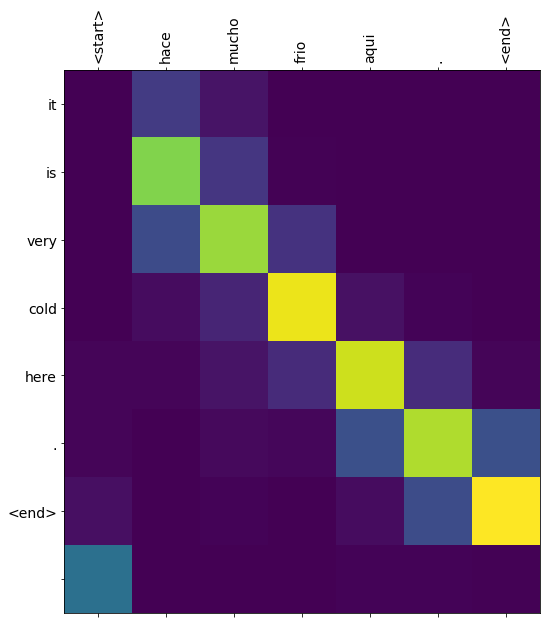

In [33]:
translate(u'Hace mucho frío aquí.')

input: <start> soy tan inteligente <end>
predict: i m so clever . <end> 


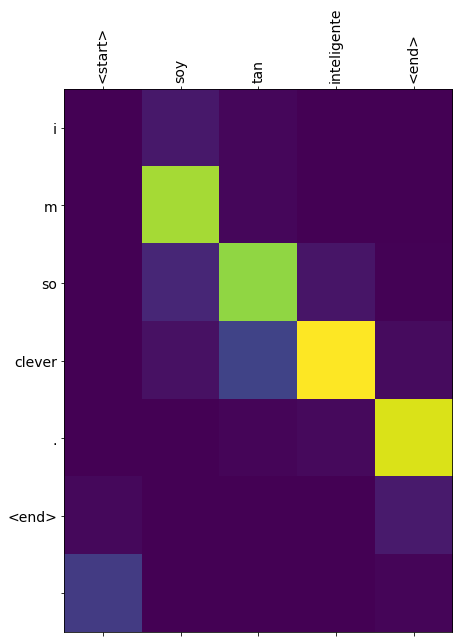

In [34]:
translate('Soy tan inteligente')

input: <start> amo el mundo y a todos . <end>
predict: i love him at . <end> 


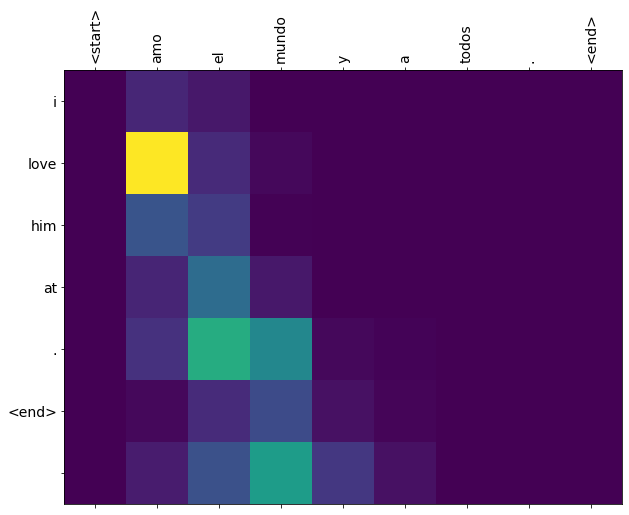

In [35]:
translate('Amo el mundo y a todos.')

In [74]:
model_path = './model/seq2seq'
encoder.save_weights('./model/seq2seq/encoder/encoder.ckpt')

In [75]:
decoder.save_weights('./model/seq2seq/decoder/decoder.ckpt')